## Comparing El Niño and ACCESS-S2 forecasts for falling below 33rd percentile of rainfall anomalies

In [1]:
# Imports
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib import cm, colors
from matplotlib.colors import LinearSegmentedColormap
import sys
sys.path.append('/home/563/rl5183/Documents/CSIRO')
import categorical_enso_functions as func

In [2]:
import warnings
warnings.simplefilter("ignore", RuntimeWarning)

In [3]:
def format_gridlines(ax, top_labels=False, bottom_labels=False, left_labels=False, right_labels=False):
    
    import cartopy.crs as ccrs
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = top_labels
    gl.bottom_labels = bottom_labels
    gl.right_labels = right_labels
    gl.left_labels = left_labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

In [4]:
# ENSO years
EN = [1963, 1965, 1968, 1969, 1972, 1976, 1977, 1979, 1982, 1986, 1987, 1991, 1994, 1997, 2002, 
      2004, 2006, 2009, 2014, 2015, 2018]

LN = [1964, 1966, 1967, 1970, 1971, 1973, 1974, 1975, 1983, 1984, 1988, 1995, 1996, 1998, 1999, 
      2000, 2005, 2007, 2010, 2011, 2017, 2020, 2021, 2022]

NN = [1960, 1961, 1962, 1978, 1980, 1981, 1985, 1989, 1990, 1992, 1993, 2001, 2003, 2008, 2012, 
      2013, 2016, 2019]

## AGCD

In [5]:
# AGCD landmask
landmask = xr.open_dataset('/g/data/w40/asp561/agcd/mask_australia_0.05deg.nc').landmask

In [6]:
# AGCD data (v2 for precip) 
file_pattern = "/g/data/zv2/agcd/v2-0-2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_{}.nc"
# Generate list of file paths for years 1960-2022
years = range(1960, 2023)  
paths = [file_pattern.format(year) for year in years]
# Open dataset 
precip = xr.open_mfdataset(paths, combine='nested', concat_dim='time', chunks={'time':12, 'lat':'auto', 'lon':'auto'}).precip

In [7]:
# Taget El Niño years 
target_years = [1982, 1986, 1987, 1991, 1994, 1997, 2002, 2004, 2006, 2009, 2014, 2015, 2018]

In [8]:
def spatial_probability_deficit(cdf, anom_data, threshold):
    P = xr.apply_ufunc(
        func.get_probability_deficit, cdf, anom_data, threshold,
        input_core_dims=[["year"], ["year"], []],  # Match time dimension
        output_core_dims=[[]],  # Remove time dim
        vectorize=True,
        dask="parallelized"
    )
    return P

In [9]:
climatologies = []
rainfall_quantiles = []
EN_probabilities = []
target_anomalies = []


for target_year in target_years:
    
    end_year = target_year - 1
    precip_target = precip.sel(time=f"{target_year}")
    precip_clim = precip.sel(time=slice(None, f"{end_year}-12"))

    clim_son = precip_clim.sel(time=precip_clim.time.dt.season == "SON").groupby("time.year").mean("time").mean("year")
    anom_son = precip_clim.sel(time=precip_clim.time.dt.season == "SON").groupby("time.year").mean("time") - clim_son
    anom_son = anom_son.where(landmask.data == 1)

    anom_son_EN = anom_son.sel(year=anom_son['year'].isin(EN)).chunk(chunks={'year': -1, 'lat': -1, 'lon': -1})
    
    q33_rainfall = anom_son.quantile(0.33, dim='year').chunk(chunks={'lat':-1, 'lon':-1})

    sorted_EN, cdf_EN = xr.apply_ufunc(
    func.empirical_cdf, 
    anom_son_EN, 
    input_core_dims=[["year"]],
    output_core_dims=[["year"], ["year"]], 
    vectorize=True,
    dask="parallelized"
    )

    P_EN_33th = spatial_probability_deficit(cdf_EN, anom_son_EN, q33_rainfall)

    anom_target = precip_target.sel(time=precip_target.time.dt.season == "SON").mean("time") - clim_son
    anom_target = anom_target.where(landmask.data == 1)

    climatologies.append(clim_son)
    rainfall_quantiles.append(q33_rainfall)
    EN_probabilities.append(P_EN_33th)
    target_anomalies.append(anom_target)

In [10]:
climatologies = xr.concat(climatologies, dim="year").assign_coords(year=target_years)
rainfall_quantiles = xr.concat(rainfall_quantiles, dim="year").assign_coords(year=target_years)
EN_probabilities = xr.concat(EN_probabilities, dim="year").assign_coords(year=target_years)
target_anomalies = xr.concat(target_anomalies, dim="year").assign_coords(year=target_years)

## ACCESS-S2

In [11]:
ds_ensemble1 = func.read_access_lag0("/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e01/maq5_pr_{}_e01.nc")
ds_ensemble2 = func.read_access_lag0("/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e02/maq5_pr_{}_e02.nc")
ds_ensemble3 = func.read_access_lag0("/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e03/maq5_pr_{}_e03.nc")

In [12]:
# Combine e1, e2, and e3
ds_combined = xr.concat([ds_ensemble1, ds_ensemble2, ds_ensemble3], dim="ensemble")

# Assign new ensemble numbers from 1 to 27
ds_combined = ds_combined.assign_coords(ensemble=np.arange(1, 28))

# Convert to mm per month and chunk 
son_lag0_yearly = (ds_combined * 30.33).chunk('auto')

In [13]:
target_anoms_lag0 = []
below_q33_lag0 = []

for target_year in target_years:
    son_lag0_target_anom = son_lag0_yearly.sel(year=target_year) - climatologies.sel(year=target_year)
    below = (son_lag0_target_anom < rainfall_quantiles.sel(year=target_year)).sum(dim="ensemble") / son_lag0_target_anom.ensemble.size
    target_anoms_lag0.append(son_lag0_target_anom)
    below_q33_lag0.append(below)

In [14]:
target_anoms_lag0 = xr.concat(target_anoms_lag0, dim="year").assign_coords(year=target_years)
below_q33_lag0 = xr.concat(below_q33_lag0, dim="year").assign_coords(year=target_years)

#### Lag 9

In [15]:
ds_ensemble1 = func.read_access_lag9("/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e01/maq5_pr_{}_e01.nc")
ds_ensemble2 = func.read_access_lag9("/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e02/maq5_pr_{}_e02.nc")
ds_ensemble3 = func.read_access_lag9("/g/data/ux62/access-s2/hindcast/calibrated/atmos/pr/monthly/e03/maq5_pr_{}_e03.nc")

In [16]:
# Combine e1, e2, and e3
ds_combined = xr.concat([ds_ensemble1, ds_ensemble2, ds_ensemble3], dim="ensemble")

# Assign new ensemble numbers from 1 to 27
ds_combined = ds_combined.assign_coords(ensemble=np.arange(1, 28))

# Convert to mm per month and chunk 
son_lag9_yearly = (ds_combined * 30.33).chunk('auto')

In [17]:
target_anoms_lag9 = []
below_q33_lag9 = []

for target_year in target_years:
    son_lag9_target_anom = son_lag9_yearly.sel(year=target_year) - climatologies.sel(year=target_year)
    below = (son_lag9_target_anom < rainfall_quantiles.sel(year=target_year)).sum(dim="ensemble") / son_lag9_target_anom.ensemble.size
    target_anoms_lag9.append(son_lag9_target_anom)
    below_q33_lag9.append(below)

In [18]:
target_anoms_lag9 = xr.concat(target_anoms_lag9, dim="year").assign_coords(year=target_years)
below_q33_lag9 = xr.concat(below_q33_lag9, dim="year").assign_coords(year=target_years)

#### Calculate Briers score for all years

In [19]:
brier_EN_means = []
brier_lag0_means = []
brier_lag9_means = []
diff_lag0_maps = []
diff_lag9_maps = []

for year in target_years:
    EN_prob = EN_probabilities.sel(year=year).where(landmask.data == 1)
    below_lag0 = below_q33_lag0.sel(year=year).where(landmask.data == 1)
    below_lag9 = below_q33_lag9.sel(year=year).where(landmask.data == 1)
    anom_target = target_anomalies.sel(year=year)
    q33_rainfall = rainfall_quantiles.sel(year=year)

    obs_binary = (anom_target < q33_rainfall).astype(int)

    brier_score_EN = ((EN_prob - obs_binary) ** 2)
    brier_score_lag0 = ((below_lag0 - obs_binary) ** 2)
    brier_score_lag9 = ((below_lag9 - obs_binary) ** 2)

    diff_lag0_maps.append(brier_score_EN - brier_score_lag0)
    diff_lag9_maps.append(brier_score_EN - brier_score_lag9)

    brier_EN_means.append(brier_score_EN.mean(dim=['lat', 'lon']).values)
    brier_lag0_means.append(brier_score_lag0.mean(dim=['lat', 'lon']).values)
    brier_lag9_means.append(brier_score_lag9.mean(dim=['lat', 'lon']).values)

diff_lag0_maps = xr.concat(diff_lag0_maps, dim="year").assign_coords(year=target_years)
diff_lag9_maps = xr.concat(diff_lag9_maps, dim="year").assign_coords(year=target_years)

brier_EN_means = np.array(brier_EN_means)
brier_lag0_means = np.array(brier_lag0_means)
brier_lag9_means = np.array(brier_lag9_means)

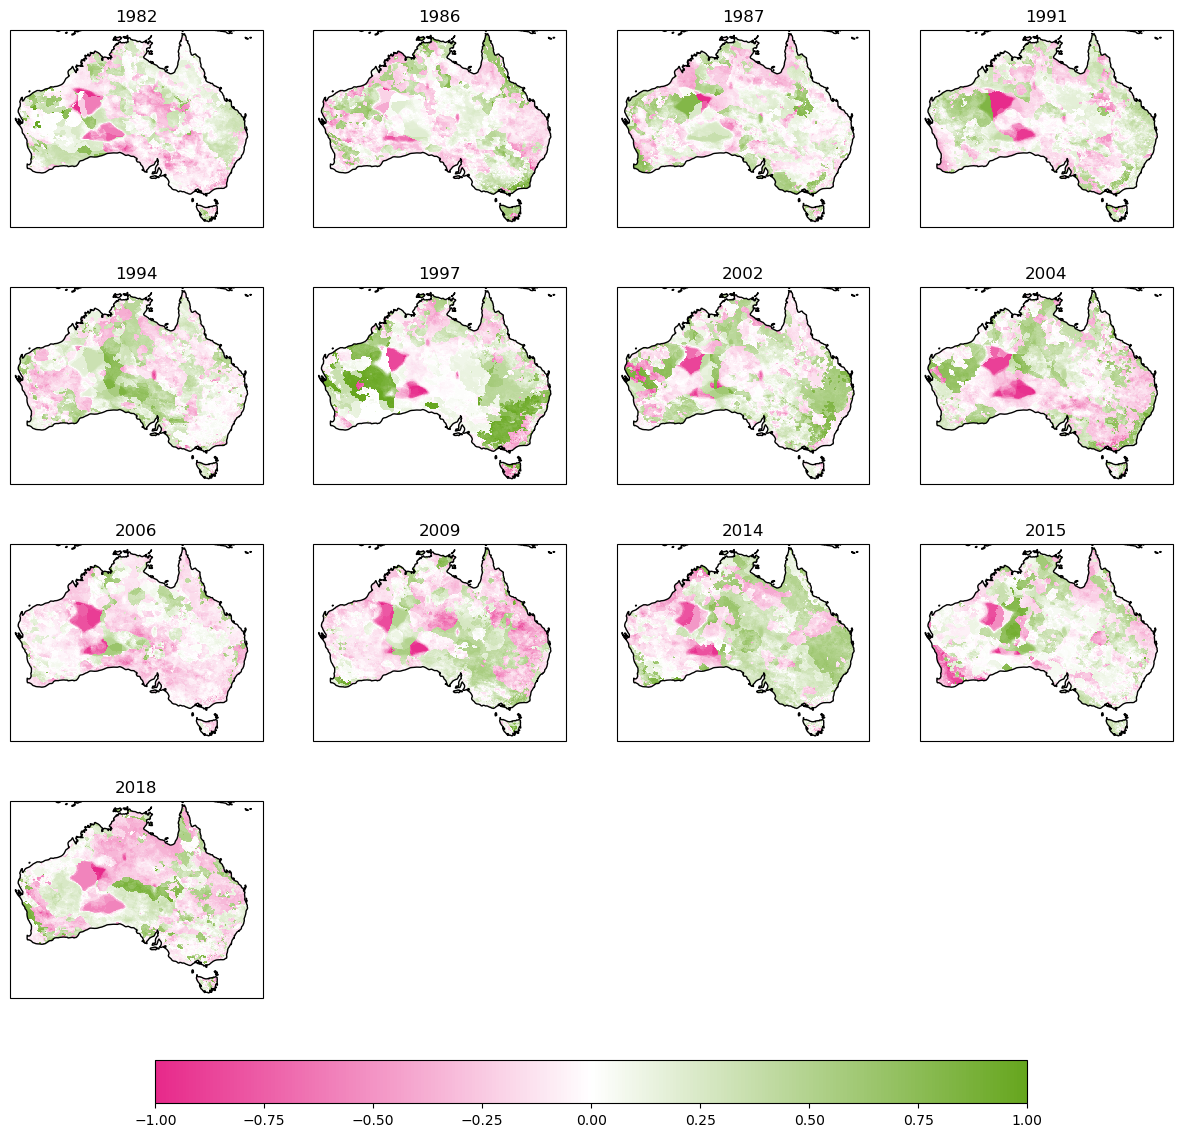

In [20]:
# Plot all years
fig = plt.figure(figsize=(15, 16))
axs = []

columns = 4
rows = 4
vmin=-1
vmax=1
cmap = LinearSegmentedColormap.from_list("pink_green", ["#e7298a", "white", "#66a61e"])

for i, year in enumerate(diff_lag0_maps.year): 
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree(180))
    im = diff_lag0_maps.sel(year=year).plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f'{year.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(im, ax=axs, orientation='horizontal', shrink=0.75, pad=0.05)

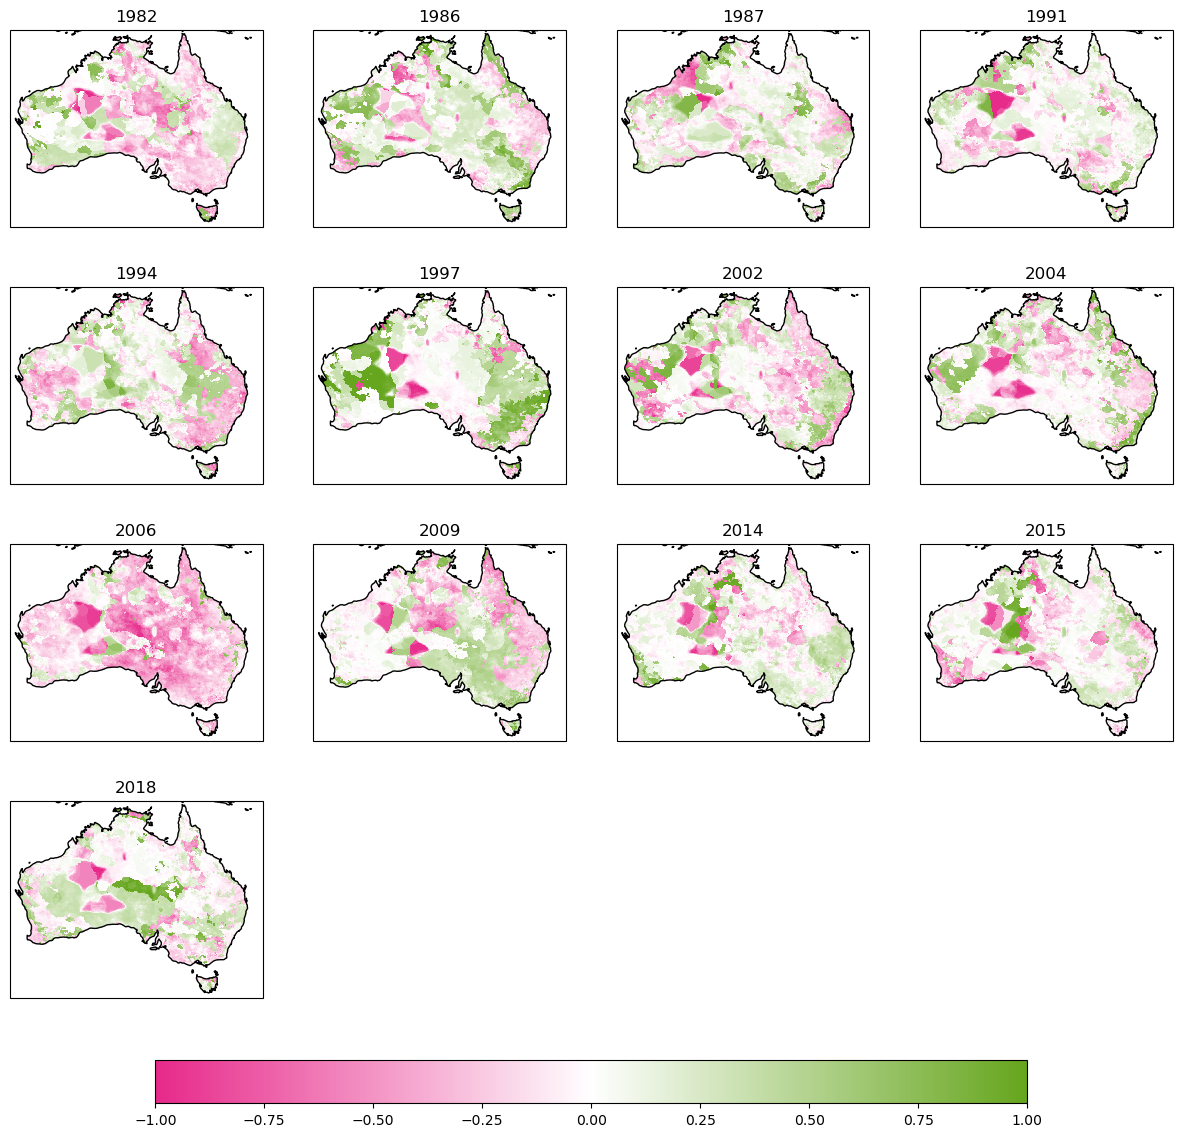

In [21]:
# Plot all years lag 9
fig = plt.figure(figsize=(15, 16))
axs = []

columns = 4
rows = 4
vmin=-1
vmax=1
cmap = LinearSegmentedColormap.from_list("pink_green", ["#e7298a", "white", "#66a61e"])

for i, year in enumerate(diff_lag0_maps.year): 
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree(180))
    im = diff_lag9_maps.sel(year=year).plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f'{year.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(im, ax=axs, orientation='horizontal', shrink=0.75, pad=0.05)

#### Average Brier score map

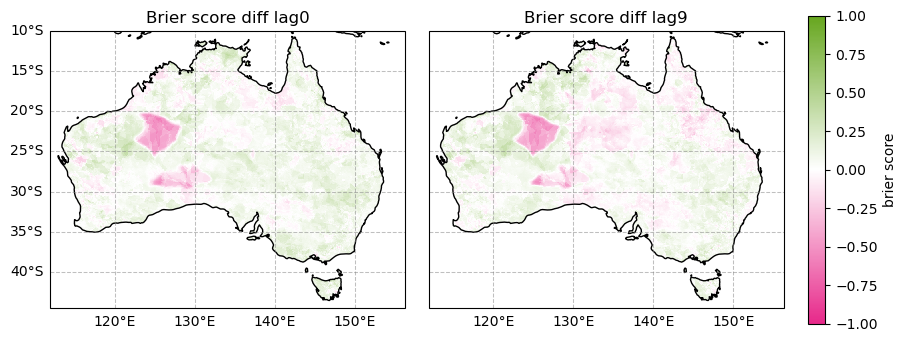

In [22]:
fig = plt.figure(figsize=(10, 4))  
gs = gridspec.GridSpec(1, 3, wspace=0.1, width_ratios=[1, 1, 0.05])
vmin = -1
vmax = 1
cmap = LinearSegmentedColormap.from_list("pink_green", ["#e7298a", "white", "#66a61e"])

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = diff_lag0_maps.mean(dim='year').plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Brier score diff lag0')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = diff_lag9_maps.mean(dim='year').plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('Brier score diff lag9')
ax = format_gridlines(ax, bottom_labels=True) 

# First colorbar for precip
cax = plt.subplot(gs[0, 2])
cbar = plt.colorbar(im, cax)
cbar.ax.set_ylabel('brier score');

#### Average Brier score through time

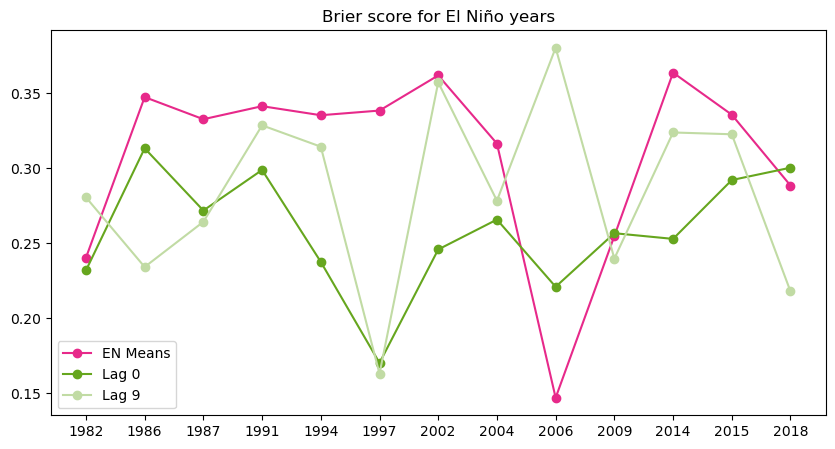

In [23]:
colors = [cmap(0.0), cmap(0.7), cmap(1.0)]
brier_x = np.arange(1,14,1)

plt.figure(figsize=(10, 5))

plt.plot(brier_x, brier_EN_means, marker='o', color=colors[0], label='EN Means')  # Pink
plt.plot(brier_x, brier_lag0_means, marker='o', color=colors[2], label='Lag 0')  # Dark Green
plt.plot(brier_x, brier_lag9_means, marker='o', color=colors[1], label='Lag 9')  # Light Green

plt.title('Brier score for El Niño years')

plt.xticks(brier_x, target_years)
plt.legend()
plt.show()